In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt

import numpy as np
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import albumentations as A
from torch.cuda.amp.grad_scaler import GradScaler
from torch.cuda.amp.autocast_mode import autocast
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, random_split
import os
from PIL import Image
import torch.optim as optim
import wandb
import glob



DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU

In [7]:
NUM_CLIENTS = 2
BATCH_SIZE = 20
IMAGE_HEIGHT = 240
IMAGE_WIDTH = 240
lr = 0.00001
epochs = 15
class WoundDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index])
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
        return image, mask

# Define the transform
# used to transform validation set
transform = A.Compose(
    [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

# Load images and masks using the custom dataset
testset = WoundDataset("data/validation_data/val_images/", "data/validation_data/val_masks", transform=transform)
testloader = DataLoader(testset, batch_size=BATCH_SIZE)

In [2]:
# how to add dropout in UNET architecture
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [9]:
def validate_model(loader, model, device="cuda"):
    """Test the network on the training set."""
    print("~~~~ In test ~~~~")
    criterion = torch.nn.BCEWithLogitsLoss()
    loss = 0
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score  = 0
    result = []
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            loss += criterion(preds, y).item()
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            num_pixels += torch.numel(preds)
            dice_score += (2 * (preds * y).sum()) / (
                (preds.sum() + y.sum()) + 1e-8
            )
            # Calculate IoU score
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            iou_score += (intersection + 1e-8) / (union + 1e-8)

    num_batches = len(loader)
    loss /= num_batches
    acc = num_correct/num_pixels*100
    diceS = dice_score/num_batches
    iouS = iou_score/num_batches
    correct_pixel = num_correct
    total_pixel = num_pixels
    print(f"Loss = {loss}")
    print(f"IoU Score = {iouS}")
    print(f"Dice Score = {diceS}")
    print("~~~~~ Out of test ~~~~~")

    model.train()
    
    result = [acc.item(), diceS.item(), iouS.item(), loss, correct_pixel.item(), total_pixel]
    
    return result

In [3]:
net = UNET().to(DEVICE)

In [11]:
#federated check point
latest_round_file = "federated/models/model_round_1.pth"
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)
results = validate_model(testloader, net, DEVICE)

Loading pre-trained model from:  federated/models/model_round_1.pth
~~~~ In test ~~~~
Loss = 0.7971822023391724
IoU Score = 0.5467222929000854
Dice Score = 0.7069430351257324
~~~~~ Out of test ~~~~~


In [13]:
labels = ["Accuracy", "Dice Score", "IOU", "Loss", "Correct Pixel", "Total Pixel"]

for label, item in zip(labels, results):
    print(f"{label}: {item}")

Accuracy: 99.20370483398438
Dice Score: 0.7069430351257324
IOU: 0.5467222929000854
Loss: 0.7971822023391724
Correct Pixel: 514272
Total Pixel: 518400


In [15]:
#central check point
# def load_checkpoint(checkpoint, model):
#     print("=> Loading checkpoint")
#     model.load_state_dict(checkpoint["state_dict"])

#load_checkpoint(torch.load("my_checkpoint.pth.tar"), net)

latest_round_file = "central/my_checkpoint.pth.tar"
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict["state_dict"])
results2 = validate_model(testloader, net, DEVICE)

Loading pre-trained model from:  central/my_checkpoint.pth.tar
~~~~ In test ~~~~
Loss = 0.7460983395576477
IoU Score = 0.17441219091415405
Dice Score = 0.29702040553092957
~~~~~ Out of test ~~~~~


In [16]:
labels = ["Accuracy", "Dice Score", "IOU", "Loss", "Correct Pixel", "Total Pixel"]

for label, item in zip(labels, results2):
    print(f"{label}: {item}")

Accuracy: 98.55729675292969
Dice Score: 0.29702040553092957
IOU: 0.17441219091415405
Loss: 0.7460983395576477
Correct Pixel: 510921
Total Pixel: 518400


In [17]:
#federated check point
latest_round_file = "federated/models/model_round_1_2client.pth"
print("Loading pre-trained model from: ", latest_round_file)
state_dict = torch.load(latest_round_file)
net.load_state_dict(state_dict)
results = validate_model(testloader, net, DEVICE)
labels = ["Accuracy", "Dice Score", "IOU", "Loss", "Correct Pixel", "Total Pixel"]

for label, item in zip(labels, results):
    print(f"{label}: {item}")

Loading pre-trained model from:  federated/models/model_round_1_2client.pth
~~~~ In test ~~~~
Loss = 0.8170226812362671
IoU Score = 0.011053388006985188
Dice Score = 0.02186509221792221
~~~~~ Out of test ~~~~~
Accuracy: 98.27410888671875
Dice Score: 0.02186509221792221
IOU: 0.011053388006985188
Loss: 0.8170226812362671
Correct Pixel: 509453
Total Pixel: 518400


In [4]:
def check_accuracy(device, loader, model):
    """Test the network on the training set."""
    print("~~~~ In test ~~~~")
    criterion = torch.nn.BCEWithLogitsLoss()

    # Move model to device before starting the loop
    model = model.to(device)
    model.eval()

    loss = 0
    num_correct = 0
    num_pixels = 0
    dice_score = 0
    iou_score = 0

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device).unsqueeze(1)
            preds = torch.sigmoid(model(x))
            loss += criterion(preds, y).item()
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum().item()  # convert tensor to python number
            num_pixels += torch.numel(preds)
            batch_dice_score = (2 * (preds * y).sum()) / (
                (preds + y).sum() + 1e-8
            )
            dice_score += batch_dice_score.item()
            # Calculate IoU score
            intersection = (preds * y).sum()
            union = (preds + y).sum() - intersection
            batch_iou_score = (intersection + 1e-8) / (union + 1e-8)
            iou_score += batch_iou_score.item()

    num_batches = len(loader)
    loss /= num_batches
    acc = num_correct/num_pixels*100
    diceS = dice_score/num_batches
    iouS = iou_score/num_batches

    print(f"Loss = {loss}")
    print(f"IoU Score = {iouS}")
    print(f"Dice Score = {diceS}")
    print("~~~~~ Out of test ~~~~~")

    # Return model to training mode
    model.train()
    return acc, diceS, loss, iouS

In [11]:
import pandas as pd
import re

def evaluate_all_models(folder_path, device, val_loader, model):
    # Initialize an empty DataFrame
    df = pd.DataFrame(columns=["round_number", "accuracy", "dice_score", "loss", "IoU_score"])

    # Get a list of all model files
    list_of_files = [fname for fname in glob.glob(f"{folder_path}/model_round_*")]

    # Loop over each file
    for file in list_of_files:
        # Extract round number from filename using regex
        round_number = re.search(r'model_round_(\d+)', file)
        round_number = int(round_number.group(1)) if round_number else None

        # Load the model parameters
        state_dict = torch.load(file)

        # Initialize a model instance and load the parameters
        model = model
        model.load_state_dict(state_dict)

        # Evaluate the model
        acc, dice_score, loss, iou_score = check_accuracy(device, val_loader, model)

        # Append the results to the DataFrame
        new_row = {
            "round_number": round_number,
            "accuracy": acc,
            "dice_score": dice_score,
            "loss": loss,
            "IoU_score": iou_score
        }
        
        df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

        # df = df.append({
        #     "round_number": round_number,
        #     "accuracy": acc,
        #     "dice_score": dice_score,
        #     "loss": loss,
        #     "IoU_score": iou_score
        # }, ignore_index=True)

    # Return the DataFrame
    return df

In [12]:
df = evaluate_all_models("federated/models/", DEVICE, testloader, net)

~~~~ In test ~~~~
Loss = 0.8179364204406738
IoU Score = 0.307037889957428
Dice Score = 0.469822496175766
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.818443775177002
IoU Score = 0.598453938961029
Dice Score = 0.748790979385376
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.8451613187789917
IoU Score = 0.5734853148460388
Dice Score = 0.7289363145828247
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.8346354365348816
IoU Score = 0.5760743618011475
Dice Score = 0.7310243248939514
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.8289299011230469
IoU Score = 0.36200717091560364
Dice Score = 0.5315789580345154
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.853980302810669
IoU Score = 0.576480507850647
Dice Score = 0.7313512563705444
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.889560341835022
IoU Score = 0.4598330855369568
Dice Score = 0.6299803256988525
~~~~~ Out of test ~~~~~
~~~~ In test ~~~~
Loss = 0.8644481897354126
IoU Score = 0.60368812084198
Dice Score = 0.75

In [18]:
def sort_df(df):
    # Sort DataFrame by 'round_number'
    sorted_df = df.sort_values(by='round_number', ascending=True)
    return sorted_df

df = sort_df(df)
df

,round_number,accuracy,dice_score,loss,IoU_score
0,1,98.790123,0.469822,0.817936,0.307038
12,2,99.221451,0.737342,0.825915,0.583960
30,4,98.830826,0.580292,0.880166,0.408741
37,5,99.290123,0.751921,0.841363,0.602463
55,7,99.183449,0.738688,0.861970,0.585650
...,...,...,...,...,...
78,97,99.185571,0.769163,0.825293,0.624911
79,98,98.904900,0.547541,0.854199,0.376975
2,100,99.039931,0.728936,0.845161,0.573485
3,101,99.225502,0.731024,0.834635,0.576074


In [19]:
import matplotlib.pyplot as plt

def plot_iou_score(df,y_min, y_max):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the dice_score column
    plt.plot(df["round_number"], df["IoU_score"], marker='o')

    # Set the title and labels
    plt.title("IoU Score per Round")
    plt.xlabel("Round Number")
    plt.ylabel("IoU Score")

    # Optional: Set the limit of y-axis
    plt.ylim([y_min, y_max])

    # Show the plot
    plt.show()

In [20]:
import matplotlib.pyplot as plt

def plot_dice_score(df,y_min, y_max):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the dice_score column
    plt.plot(df["round_number"], df["dice_score"], marker='o')

    # Set the title and labels
    plt.title("dice score per Round")
    plt.xlabel("Round Number")
    plt.ylabel("dice score")

    # Optional: Set the limit of y-axis
    plt.ylim([y_min, y_max])

    # Show the plot
    plt.show()

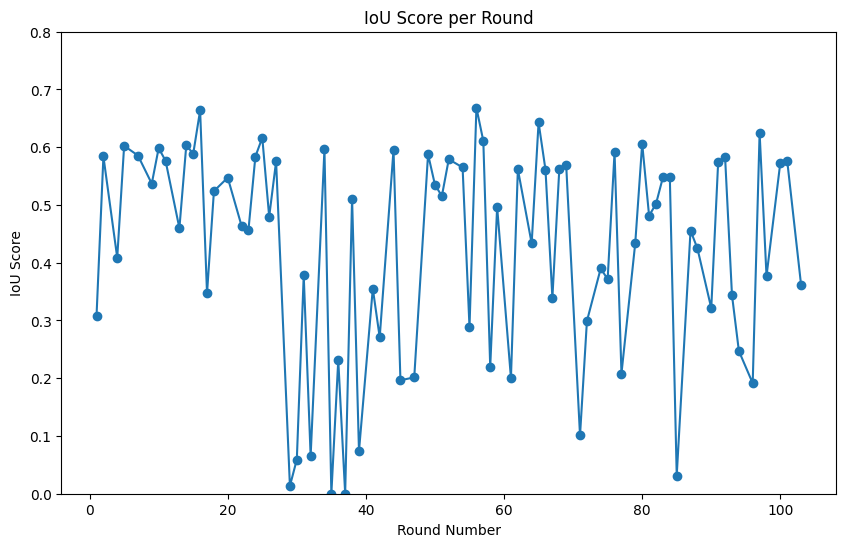

In [24]:
plot_iou_score(df, y_min=0, y_max=0.8)

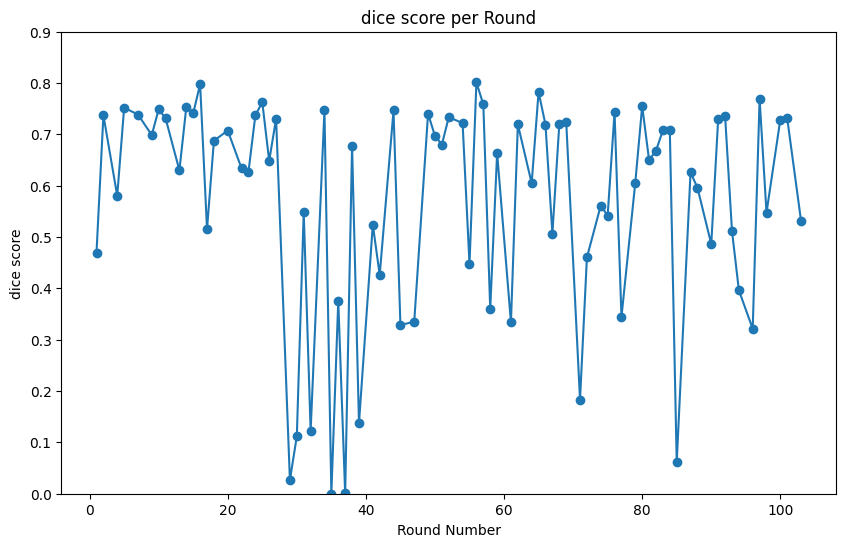

In [27]:
plot_dice_score(df, y_min=0, y_max=0.9)

In [28]:
import matplotlib.pyplot as plt

def plot_loss(df,y_min, y_max):
    # Set the figure size
    plt.figure(figsize=(10, 6))

    # Plot the dice_score column
    plt.plot(df["round_number"], df["loss"], marker='o')

    # Set the title and labels
    plt.title("loss per Round")
    plt.xlabel("Round Number")
    plt.ylabel("loss")

    # Optional: Set the limit of y-axis
    plt.ylim([y_min, y_max])

    # Show the plot
    plt.show()

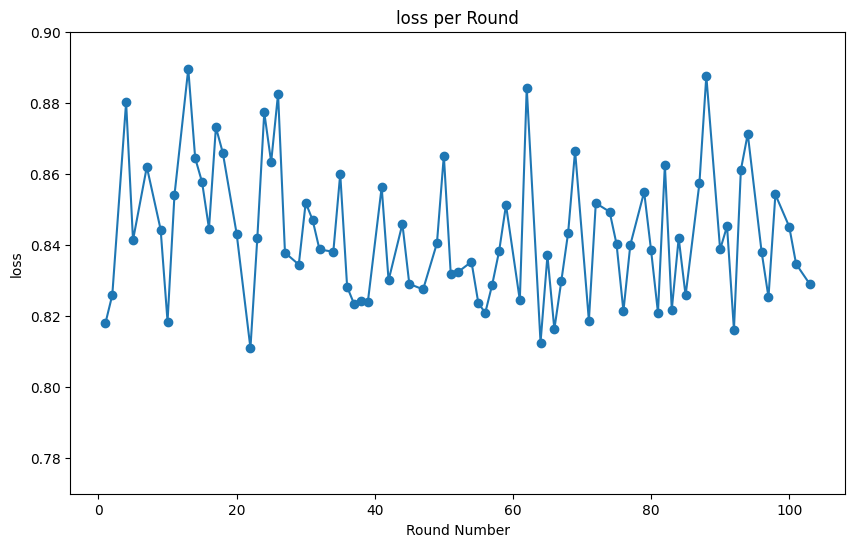

In [31]:
plot_loss(df, y_min=0.77, y_max=0.9)